In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

## Load Data

In [3]:
epoch_key = ('jaq', 1, 2) # animal, day, epoch

In [4]:
from src.load_data import load_data

data = load_data(epoch_key)

INFO:src.load_data:Loading position information and linearizing...
INFO:src.load_data:Loading multiunits...


In [5]:
from replay_trajectory_classification import ClusterlessDecoder

decoder = ClusterlessDecoder(transition_type='empirical_movement', replay_speed=40, place_bin_size=3)

In [6]:
decoder.fit(
    position=data['position_info'].linear_position,
    multiunits=data['multiunits'],
    is_training=data['position_info'].speed > 4)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting multiunits...


ClusterlessDecoder(infer_track_interior=True,
                   initial_conditions_type='uniform_on_track',
                   model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                   movement_var=0.05,
                   occupancy_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                   occupancy_model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   place_bin_size=3, position_range=None, replay_speed=40,
                   transition_type='empirical_movement')

In [7]:
from src.load_data import make_track_graph

track_graph, center_well_id = make_track_graph()

In [8]:
place_bin_centers = decoder.place_bin_centers_

## Make State Transition

In [9]:
from scipy.interpolate import interp1d
import networkx as nx

track_graph1 = track_graph.copy()
n_nodes = len(track_graph.nodes)
n_bins = 100

for edge_ind, (node1, node2) in enumerate(track_graph.edges):
    node1_x_pos, node1_y_pos = track_graph.nodes[node1]['pos']
    node2_x_pos, node2_y_pos = track_graph.nodes[node2]['pos']
    f = interp1d((node1_x_pos, node2_x_pos), (node1_y_pos, node2_y_pos))
    xnew = np.linspace(node1_x_pos, node2_x_pos, num=n_bins, endpoint=True)    
    xy = np.stack((xnew, f(xnew)), axis=1)
    dist = np.linalg.norm(np.diff(xy, axis=0), axis=1)
    new_node_ids = n_nodes + np.arange(len(dist))
    nx.add_path(track_graph1, [node1, *new_node_ids, node2], distance=dist[0])
    track_graph1.remove_edge(node1, node2)
    for id, pos in zip(new_node_ids, xy):
        track_graph1.nodes[id]['pos'] = pos
        track_graph1.nodes[id]['track_segment_id'] = edge_ind
    track_graph1.nodes[node1]['track_segment_id'] = edge_ind
    track_graph1.nodes[node2]['track_segment_id'] = edge_ind
    n_nodes = len(track_graph1.nodes)
    

In [10]:
distance = dict(nx.all_pairs_dijkstra_path_length(track_graph1, weight='distance'))

In [14]:
from scipy.ndimage import label

EDGE_ORDER = [6, 5, 3, 8, 7, 4, 2, 0, 1]

labels, _ = label(decoder.is_track_interior_)
bin_edge = []
for label in labels:
    if label != 0:
        bin_edge.append(f'{EDGE_ORDER[label-1]}')
    else:
        bin_edge.append('')

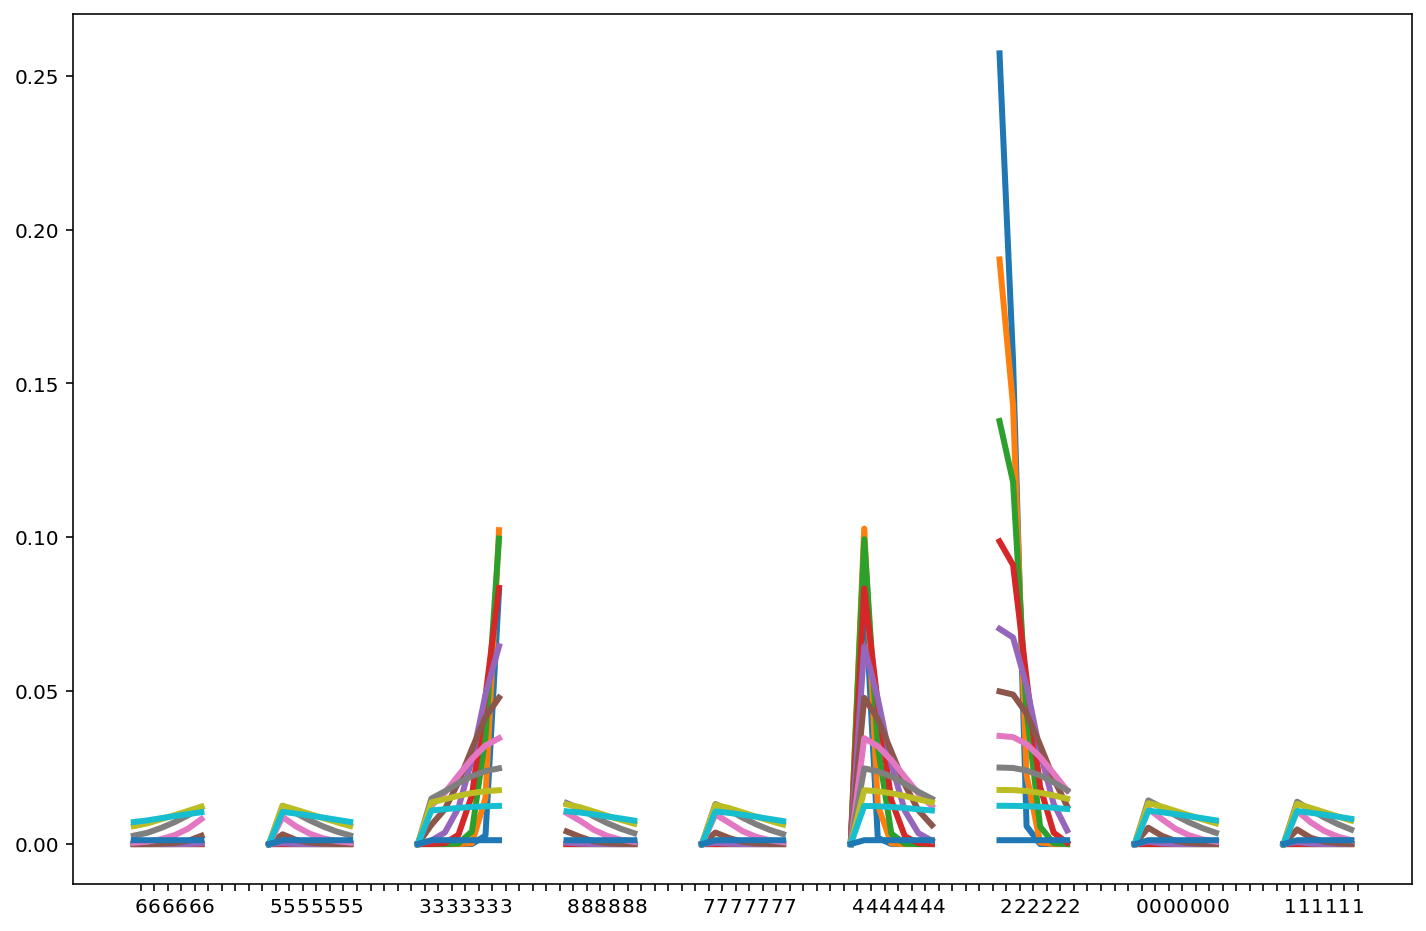

In [15]:
from scipy.stats import multivariate_normal
from src.load_data import convert_linear_distance_to_linear_position
import pandas as pd

def get_node_id_to_bin_ind(distance, center_well_id, track_graph1, place_bin_centers):

    node_ids, linear_distance = list(zip(*distance[center_well_id].items()))
    ids = nx.get_node_attributes(track_graph1, 'track_segment_id')
    track_segment_id = np.array([ids[node_id] for node_id in node_ids])
    linear_distance = np.array(linear_distance)


    EDGE_ORDER = [6, 5, 3, 8, 7, 4, 2, 0, 1]

    linear_position = convert_linear_distance_to_linear_position(
        linear_distance, track_segment_id, EDGE_ORDER, spacing=15)
    place_bin_ind = np.digitize(linear_position, place_bin_centers.squeeze())
    return pd.Series({node_id: bin_ind for node_id, bin_ind in zip(node_ids, place_bin_ind)}, name='bin_ind')


def get_st(linear_distance, node_id_to_bin_ind, place_bin_centers, replay_speed=1, movement_var=4):

    gaussian = multivariate_normal(
            mean=0, cov=movement_var * replay_speed)
    pdf = pd.Series(linear_distance, name='pdf').transform(lambda x: gaussian.pdf(x))
    pdf = pd.concat((pdf, node_id_to_bin_ind), axis=1).groupby('bin_ind').mean()
    pdf = pdf[pdf.index < place_bin_centers.size]

    st = np.zeros_like(place_bin_centers)
    st[pdf.index.values] = pdf.values
    
    return st


node_id_to_bin_ind = get_node_id_to_bin_ind(distance, center_well_id, track_graph1, place_bin_centers)
mask = np.ones_like(place_bin_centers)
mask[~decoder.is_track_interior_] = np.nan

fig, ax = plt.subplots(figsize=(12, 8))
for movement_var in [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 100000]:
    st = get_st(distance[300], node_id_to_bin_ind, place_bin_centers, movement_var=movement_var)
    ax.plot(np.arange(place_bin_centers.size), st * mask, linewidth=3);

ax.set_xticks(np.arange(place_bin_centers.size) + 0.5)
ax.set_xticklabels(bin_edge);

In [16]:
from replay_trajectory_classification.state_transition import _normalize_row_probability

state_transition = np.zeros((place_bin_centers.size, place_bin_centers.size))

for bin_ind, df in node_id_to_bin_ind.sort_values().reset_index().groupby('bin_ind'):
    if bin_ind < place_bin_centers.size:
        state_transition[bin_ind] = np.mean(
            [get_st(distance[node_id], node_id_to_bin_ind, place_bin_centers)
             for node_id in df['index'].values], axis=0).squeeze()
        
state_transition = _normalize_row_probability(state_transition)

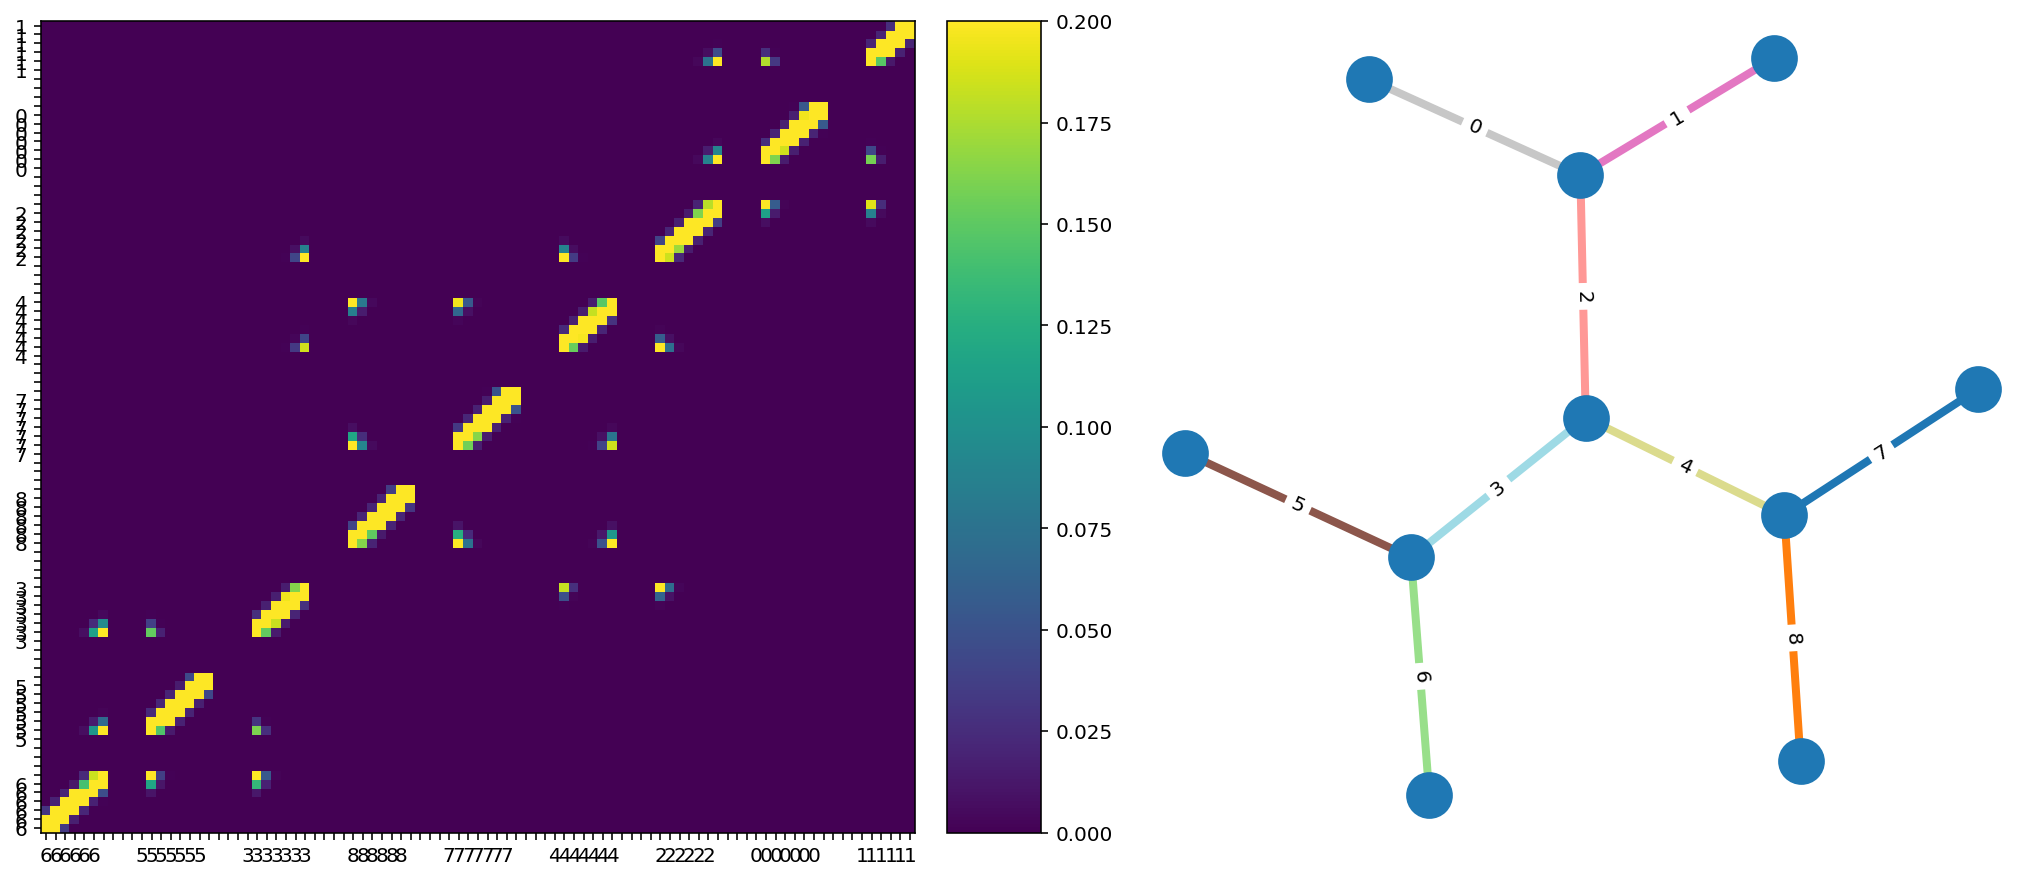

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
m = axes[0].pcolormesh(state_transition, vmin=0.0, vmax=0.2)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)
axes[0].set_yticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_yticklabels(bin_edge)
plt.colorbar(m, ax=axes[0]);

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[1],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[1], edge_labels=edge_labels);
plt.axis('off');

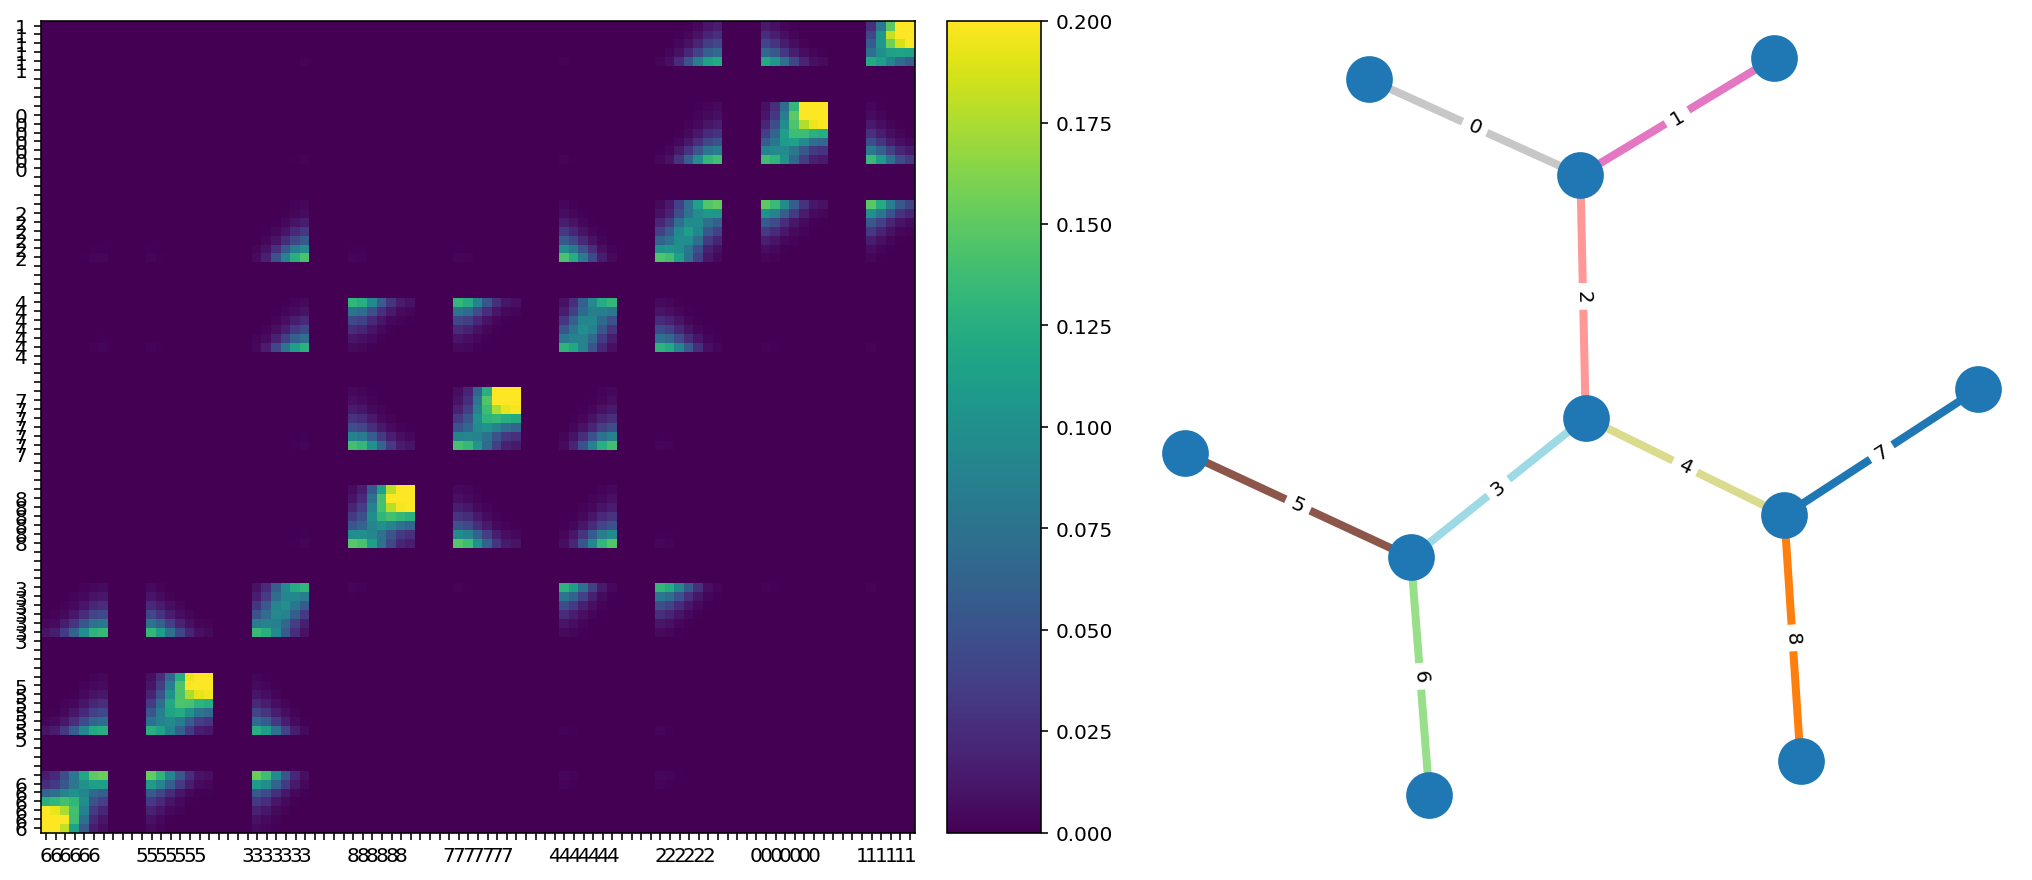

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
m = axes[0].pcolormesh(np.linalg.matrix_power(state_transition.T, 10), vmin=0.0, vmax=0.2)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)
axes[0].set_yticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_yticklabels(bin_edge)
plt.colorbar(m, ax=axes[0]);

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[1],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[1], edge_labels=edge_labels);
plt.axis('off');



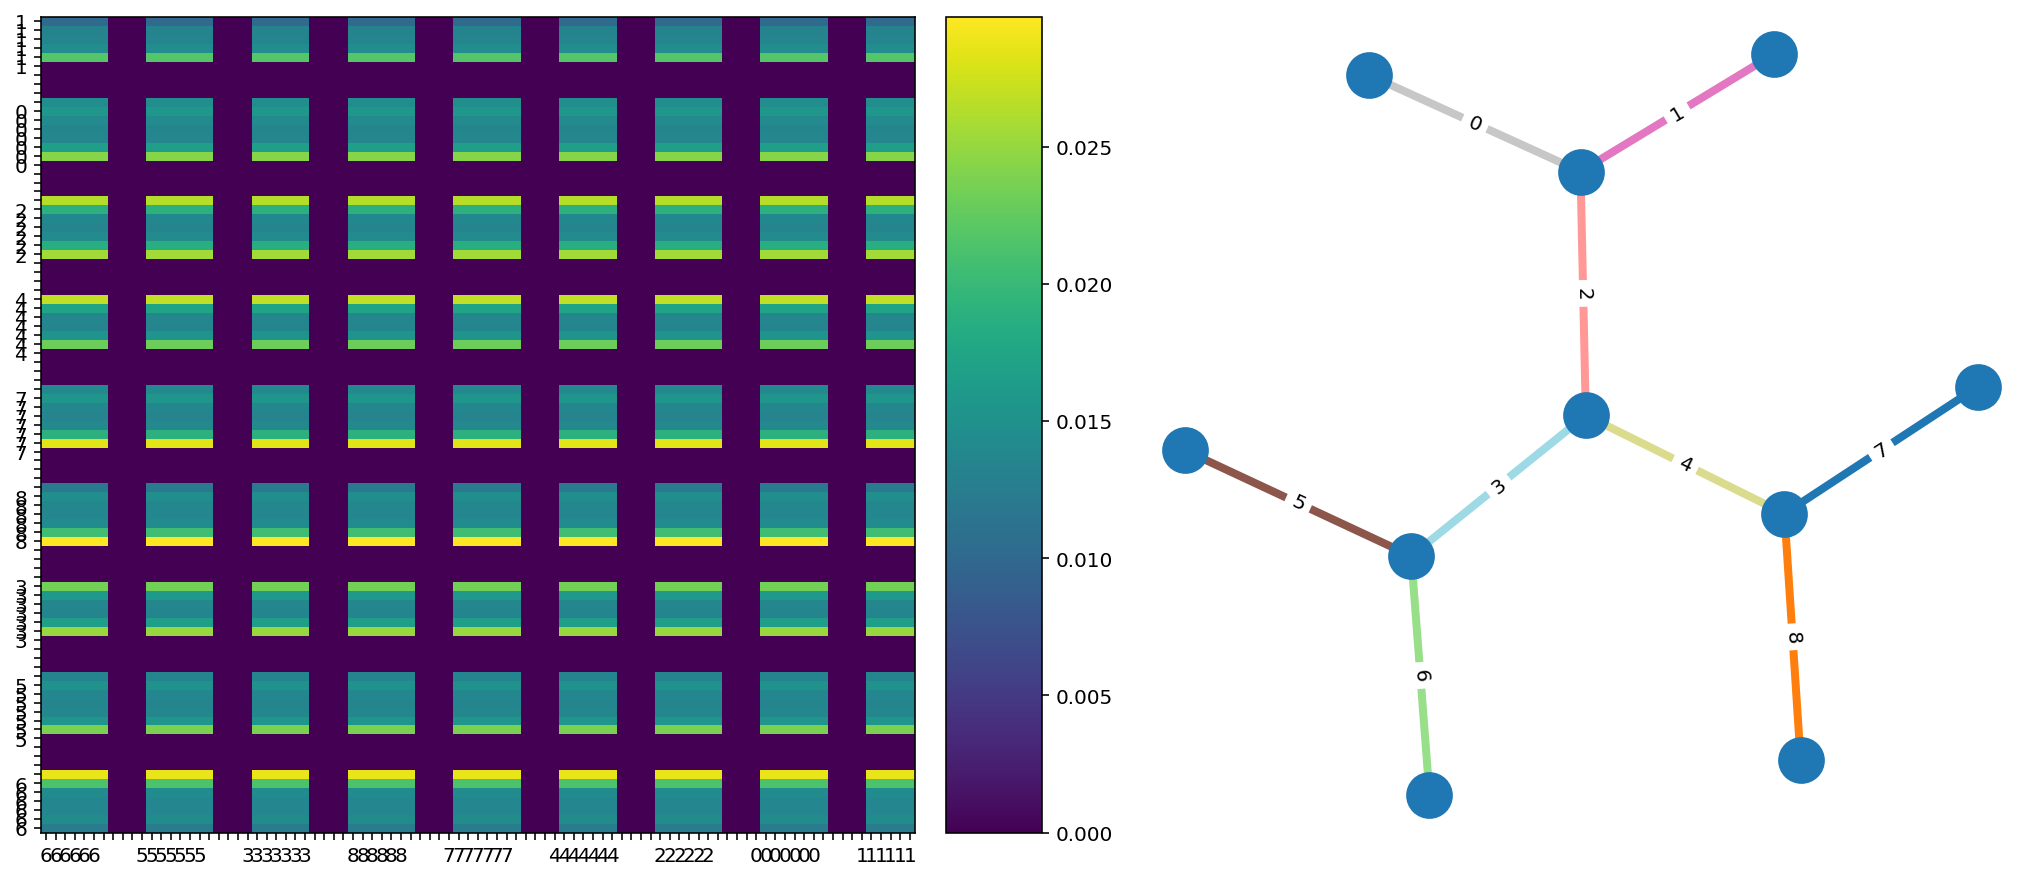

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
m = axes[0].pcolormesh(np.linalg.matrix_power(state_transition.T, 10000))
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)
axes[0].set_yticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_yticklabels(bin_edge)
plt.colorbar(m, ax=axes[0]);

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[1],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[1], edge_labels=edge_labels);
plt.axis('off');



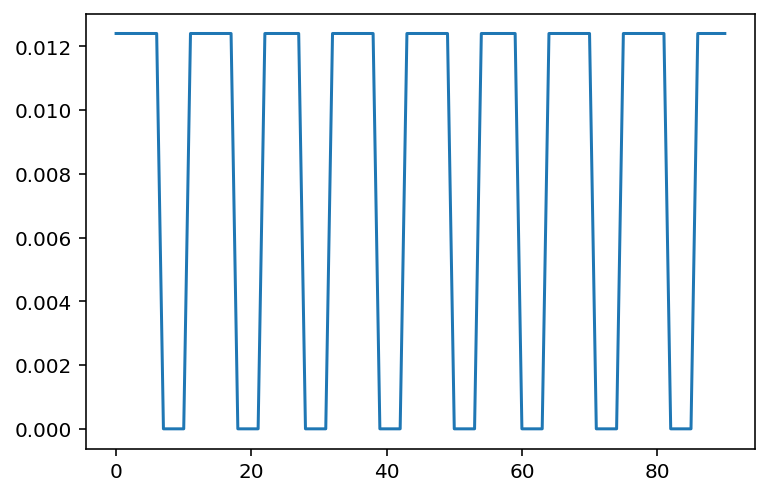

In [32]:
plt.plot(np.linalg.matrix_power(state_transition.T, 10000)[0])

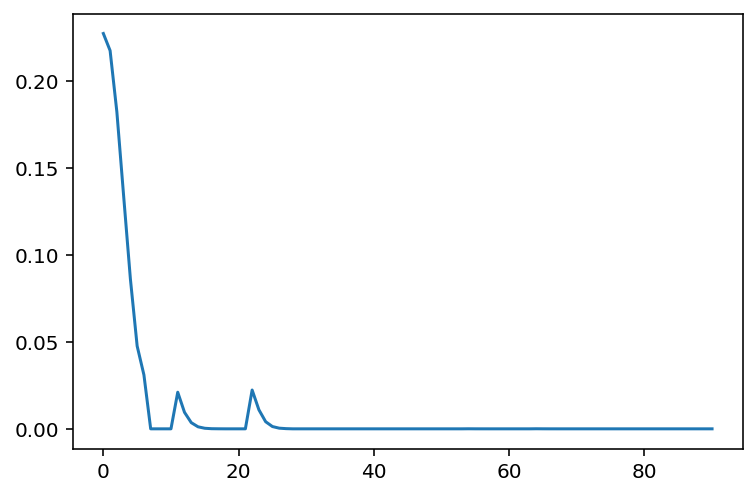

In [341]:
plt.plot(np.linalg.matrix_power(state_transition, 1)[0])